## Early Predictor for Student Success Based on Behavioural and Demographical Indicators

Import libraries

In [53]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Load data

In [54]:
zf = zipfile.ZipFile('./data.zip')
student_info = pd.read_csv(zf.open('studentInfo.csv'))
student_vle = pd.read_csv(zf.open('studentVle.csv'))
student_assessment = pd.read_csv(zf.open('studentAssessment.csv'))
student_registration = pd.read_csv(zf.open('studentRegistration.csv'))
assessments = pd.read_csv(zf.open('assessments.csv'))

Basic information about modules, first assessments and number of registered students

In [55]:
# Get information about first day assessments
basic_info = assessments.filter(items=['code_module', 'code_presentation', 'date'])
basic_info = basic_info.groupby(['code_module', 'code_presentation']).min()
basic_info = pd.merge(basic_info, assessments, on=['code_module', 'code_presentation', 'date'],
                             how='inner').filter(items=['code_module', 'code_presentation', 'id_assessment', 'date'])

# Get total number of registered students for each module
registrations = student_registration.filter(items=['code_module', 'code_presentation', 'id_student']).groupby(
    ['code_module', 'code_presentation']).count().reset_index()
basic_info.insert(4, "number of registered students", registrations['id_student'])
basic_info

,code_module,code_presentation,id_assessment,date,number of registered students
0,AAA,2013J,1752,19.0,383
1,AAA,2014J,1758,19.0,365
2,BBB,2013B,14984,19.0,1767
3,BBB,2013J,14996,19.0,2237
4,BBB,2014B,15008,12.0,1613
5,BBB,2014J,15020,19.0,2292
6,CCC,2014B,24286,18.0,1936
7,CCC,2014J,24295,18.0,2498
8,DDD,2013B,25341,23.0,1303
9,DDD,2013J,25348,25.0,1938


### Data preparation

In [56]:
clicks_before_start = student_vle[student_vle['date'] < 0]

# Merge student_info and student_registration tables to get registration_date
df1 = pd.merge(student_info, student_registration, how='left', on=['id_student', 'code_module', 'code_presentation'])

# Merge previous table with basic_info that was created earlier to get first assessment days and ids
df2 = pd.merge(df1, basic_info, on=['code_module', 'code_presentation'], how='left')

# Merge previous table with student assessment to find student's scores on their first assessments
df3 = pd.merge(df2, student_assessment, on=['id_assessment', 'id_student'], how='left')

# Merge previous table with clicks_before_start table that was created earlier
data = pd.merge(df3, clicks_before_start, on=['id_student', 'code_module', 'code_presentation'], how='left')

# Keep only columns that are needed later
data = data.filter(['code_module', 'code_presentation', 'id_student', 'score', 'highest_education', 'sum_click',
                    'date_registration', 'age_band',
                    'disability', 'gender', 'num_of_prev_attempts', 'final_result'])
data.fillna(value=0, inplace=True)

# Get number of clicks before course start
data = data.groupby(
    ['code_module', 'code_presentation', 'id_student', 'score', 'highest_education', 'date_registration',
     'age_band', 'disability', 'gender', 'num_of_prev_attempts', 'final_result']).sum().reset_index()

# Get the final dataframe that will be used
data = data[['id_student', 'gender', 'highest_education', 'age_band', 'num_of_prev_attempts', 'disability', 'score',
             'date_registration', 'sum_click', 'final_result']]
data.rename(columns={'score': 'first_assignment', 'sum_click': 'clicks_before_start',
                     'num_of_prev_attempts': 'previous_attempts', 'age_band': 'age'}, inplace=True)
data.head()

,id_student,gender,highest_education,age,previous_attempts,disability,first_assignment,date_registration,clicks_before_start,final_result
0,11391,M,HE Qualification,55<=,0,N,78.0,-159.0,98.0,Pass
1,28400,F,HE Qualification,35-55,0,N,70.0,-53.0,215.0,Pass
2,30268,F,A Level or Equivalent,35-55,0,Y,0.0,-92.0,102.0,Withdrawn
3,31604,F,A Level or Equivalent,35-55,0,N,72.0,-52.0,169.0,Pass
4,32885,F,Lower Than A Level,0-35,0,N,69.0,-176.0,295.0,Pass


Converting all categorical variables into dichotomous variables.

In [57]:
education_mapping = {
    'No Formal quals': 0,
    'Lower Than A Level': 0,
    'A Level or Equivalent': 0,
    'HE Qualification': 1,
    'Post Graduate Qualification': 1
}

age_mapping = {
    '0-35': 0,
    '35-55': 1,
    '55<=': 1
}

grade_mapping = {
    'Withdrawn': -1,
    'Fail': -1,
    'Pass': 1,
    'Distinction': 1
}

gender_mapping = {
    'F': 1,
    'M': 0
}

disability_mapping = {
    'N': 0,
    'Y': 1
}

data['highest_education'] = data['highest_education'].map(education_mapping)
data['age'] = data['age'].map(age_mapping)
data['final_result'] = data['final_result'].map(grade_mapping)
data['gender'] = data['gender'].map(gender_mapping)
data['disability'] = data['disability'].map(disability_mapping)

data.head()

,id_student,gender,highest_education,age,previous_attempts,disability,first_assignment,date_registration,clicks_before_start,final_result
0,11391,0,1,1,0,0,78.0,-159.0,98.0,1
1,28400,1,1,1,0,0,70.0,-53.0,215.0,1
2,30268,1,0,1,0,1,0.0,-92.0,102.0,-1
3,31604,1,0,1,0,0,72.0,-52.0,169.0,1
4,32885,1,0,0,0,0,69.0,-176.0,295.0,1


In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['first_assignment', 'highest_education', 'gender', 'age', 'clicks_before_start', 'date_registration']],
                                                    data['final_result'], test_size=0.3, random_state=2)

### Decision Tree

In [59]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(class_weight='balanced', min_samples_split=10)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_samples_split=10)

### Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', min_samples_split=10)
random_forest.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', min_samples_split=10, n_jobs=-1)

### BART

In [61]:
from bartpy.sklearnmodel import SklearnModel as BART

bart = BART(n_burn=200, n_chains=2, n_samples=200, n_trees=50, alpha=0.9, beta=1.5)
bart.fit(X_train, y_train)

SklearnModel(alpha=0.9, beta=1.5, n_chains=2, n_trees=50)

### KNN Classifier
#### Grid search for optimal number of neighbors

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# knn = KNeighborsClassifier(n_jobs=-1)
#
# param_grid = {'n_neighbors': np.arange(1, 150)}
# knn_gscv = GridSearchCV(knn, param_grid, cv=5)
# knn_gscv.fit(X_train, y_train)
print("Result of grid search: {n_neighbors=136}")

Result of grid search: {n_neighbors=136}


In [63]:
knn = KNeighborsClassifier(n_neighbors=136, n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=136)

### SVC
#### Grid search for optimal parameters, do not run the grid search again (it lasts for hours, literally)

In [64]:
from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
#
# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf']}
#
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
#
#
# grid.fit(X_train, y_train)
# print(grid.best_params_)

print("Result of grid search: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}")

Result of grid search: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [65]:
svc = SVC(C=1000, gamma=0.001)
svc.fit(X_train, y_train)

SVC(C=1000, gamma=0.001)

### Logistic regression

In [66]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(n_jobs=-1)
log_reg.fit(X_train, y_train)

LogisticRegression(n_jobs=-1)

In [67]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

results = []

for model in [decision_tree, random_forest, bart, knn, svc, log_reg]:
    for score in [precision_score, recall_score, f1_score, accuracy_score]:
        if model == bart:
            results.append(score(y_pred=[1 if res >= 0 else -1 for res in model.predict(X_test)], y_true=y_test))
        else:
            results.append(score(y_pred=model.predict(X_test), y_true=y_test))
split = np.array_split(results, 6)


multi = pd.MultiIndex.from_product(
    [['Pass vs Fail'], ['Precision', 'Recall', 'F1', 'Accuracy']],
    names=['Final result', 'Metric'])

results = pd.DataFrame(index=multi, columns=['Decision tree', 'Random forest', 'BART', 'KNN', 'SVC', 'Logistic regression'],
                       data={'Decision tree': split[0], 'Random forest': split[1], 'BART': split[2], 'KNN': split[3], 'SVC': split[4], 'Logistic regression': split[5]})
results


Decision tree  Random forest      BART       KNN  \
Final result Metric                                                        
Pass vs Fail Precision       0.656095       0.677194  0.687147  0.677347   
             Recall          0.675993       0.806066  0.831269  0.844297   
             F1              0.665895       0.736031  0.752368  0.751664   
             Accuracy        0.675189       0.723154  0.737983  0.732870   

                             SVC  Logistic regression  
Final result Metric                                    
Pass vs Fail Precision  0.668801             0.690242  
             Recall     0.803076             0.823366  
             F1         0.729814             0.750950  
             Accuracy   0.715279             0.738495

### Predviđanje u koji <i> IMD </i> raspon student upada

[IMD (engl. <i>Index of multiple deprivation</i>)](https://en.wikipedia.org/wiki/Multiple_deprivation_index) predstavlja mjeru siromaštva po manjim regijama (cjelinama) unutar Velike Britanije. Indeks se temelji na 7 faktora od kojih svaki ima svoju težinu.

<ul>
    <li>Prihod (22.5%)</li>
    <li>Zaposlenost (22.5%)</li>
    <li>Obrazovanje (13.5%)</li>
    <li>Zdravlje (13.5%)</li>
    <li>Zločin (9.3%)</li>
    <li>Prepreke za stanovanje i usluge (9.3%)</li>
    <li>Životno okruženje (9.3%)</li>
</ul>

Na temelju prosječnog rezultata studenta u svim predanim zadacima, starosti i razini obrazovanja pokušati će se odrediti kojem rasponu student pripada. Manji rasponi (npr. <i>0-10%</i>) označavaju siromašnije regije, a veći rasponi (npr. <i>80-90%</i>) označavaju manje siromašne regije (ne nužno bogate).

<AxesSubplot:ylabel='imd_band'>

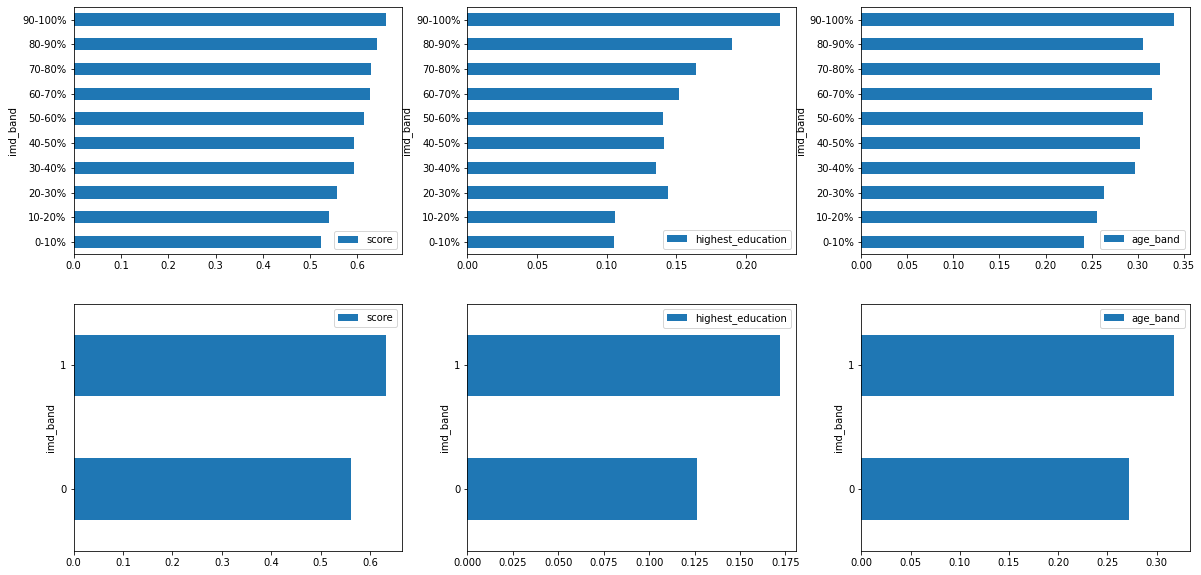

In [69]:
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

scaler = MinMaxScaler()

student_info.loc[student_info['imd_band'] == '10-20', 'imd_band'] = '10-20%'
unique_regions = student_info.groupby('imd_band').size().reset_index(name='counts')
student_avg_score = student_assessment[['id_student', 'score']].groupby('id_student').mean()
student_avg_score = pd.merge(student_info, student_avg_score, on='id_student', how='left')
student_avg_score['score'].fillna(0, inplace=True)
student_avg_score.dropna(subset = ['imd_band'], inplace=True)

student_avg_score.loc[(student_avg_score['highest_education'] == 'No Formal quals') | (student_avg_score['highest_education'] == 'A Level or Equivalent') | (student_avg_score['highest_education'] == 'Lower Than A Level'), 'highest_education'] = 0
student_avg_score.loc[(student_avg_score['highest_education'] == 'HE Qualification') | (student_avg_score['highest_education'] == 'Post Graduate Qualification') , 'highest_education'] = 1
student_avg_score['highest_education'] = pd.to_numeric(student_avg_score['highest_education'])

student_avg_score.loc[(student_avg_score['age_band'] == '0-35'), 'age_band'] = 0
student_avg_score.loc[(student_avg_score['age_band'] == '55<=') | (student_avg_score['age_band'] == '35-55'), 'age_band'] = 1
student_avg_score['age_band'] = pd.to_numeric(student_avg_score['age_band'])

student_avg_score_scaled = scaler.fit_transform(student_avg_score[['score', 'highest_education', 'age_band']])
student_avg_score['score'] = student_avg_score_scaled[:,0]

imd_avg_score = student_avg_score[['imd_band', 'score']].groupby('imd_band', as_index=False).mean()
imd_avg_edu = student_avg_score[['imd_band', 'highest_education']].groupby('imd_band', as_index=False).mean()
imd_avg_age = student_avg_score[['imd_band', 'age_band']].groupby('imd_band', as_index=False).mean()

imd_avg_score.plot(x='imd_band', y='score', ax=axs[0, 0], kind='barh')
imd_avg_edu.plot(x='imd_band', y='highest_education', ax=axs[0, 1], kind='barh')
imd_avg_age.plot(x='imd_band', y='age_band', ax=axs[0, 2], kind='barh')

student_avg_score.loc[(student_avg_score['imd_band'] == '0-10%') |
                     (student_avg_score['imd_band'] == '10-20%') |
                     (student_avg_score['imd_band'] == '20-30%') |
                     (student_avg_score['imd_band'] == '30-40%') |
                     (student_avg_score['imd_band'] == '40-50%'), 'imd_band'] = 0

student_avg_score.loc[(student_avg_score['imd_band'] == '50-60%') |
                     (student_avg_score['imd_band'] == '60-70%') |
                     (student_avg_score['imd_band'] == '70-80%') |
                     (student_avg_score['imd_band'] == '80-90%') |
                     (student_avg_score['imd_band'] == '90-100%'), 'imd_band'] = 1

student_avg_score['imd_band'] = pd.to_numeric(student_avg_score['imd_band'])


imd_avg_score = student_avg_score[['imd_band', 'score']].groupby('imd_band', as_index=False).mean()
imd_avg_edu = student_avg_score[['imd_band', 'highest_education']].groupby('imd_band', as_index=False).mean()
imd_avg_age = student_avg_score[['imd_band', 'age_band']].groupby('imd_band', as_index=False).mean()

imd_avg_score.plot(x='imd_band', y='score', ax=axs[1, 0], kind='barh')
imd_avg_edu.plot(x='imd_band', y='highest_education', ax=axs[1, 1], kind='barh')
imd_avg_age.plot(x='imd_band', y='age_band', ax=axs[1, 2], kind='barh')

Već kroz eksploratornu analizu podataka može se vidjeti blagi rast u prosječnom rezultatu u manje siromašnim regijama. Također, pokazuje se i da u pravilu siromašnije regije imaju mlađe stanovništvo te manje obrazovano stanovništvo. Naravno, to ne govori puno i potrebno je primijeniti model prije donošenja zaključaka..

Prije primjene samih modela varijabla <i>imd_band</i> će se pretvoriti u dihotomnu varijablu gdje će svi rasponi od uključivo "40-50%" biti označeni s 0, a svi rasponi iznad "40-50%" će biti označeni s 1. Tako se može reći da se varijabla sada dijeli na siromašnije i manje siromašne regije.

Model koji će se koristiti za klasifikaciju je <b><i>k-Nearest Neighbors</i></b>.

In [70]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV

X_train_imd, X_test_imd, y_train_imd, y_test_imd = train_test_split(student_avg_score[['score', 'age_band', 'highest_education']], student_avg_score['imd_band'], test_size=0.3, random_state=2)

#parameters = {"n_neighbors": range(1, 200)}
#knn_imd = GridSearchCV(KNeighborsClassifier(), parameters)
#knn_imd.fit(X_train_imd, y_train_imd)

print(f"Najbolji broj susjeda: 156") # Izračunato gornjim kodom

knn_imd = KNeighborsClassifier(n_neighbors=156)
knn_imd.fit(X_train_imd, y_train_imd)
result_test_imd = knn_imd.predict(X_test_imd)

print(f"Preciznost klasifikacije na skupu za provjeru: {accuracy_score(y_test_imd, result_test_imd)}")

Najbolji broj susjeda: 156
Preciznost klasifikacije na skupu za provjeru: 0.563790365272631


Iz dobivenih rezultata može se zaključiti da model kNN na temelju danih vrijednosti ne može sa sigurnošću odrediti kojem IMD rasponu pripada koji student. Preciznost na skupu za provjeru je svega ~56% što je marginalno bolje nego kad bi model nasumično pogađao.

Drugi model koji će se koristiti je <i><b>Random Forest</b></i> model. Razlika je u tome što će se ovaj put modelu predati gotovo sve varijable te će sam model odlučiti koje su najvažnije. Neke od izmjena su u varijabli 'gender' (M → 1, F → 0), u varijabli 'disability' (Y → 1, N → 0) i varijabli 'final_result' (Pass, Distinction → 1, Withdrawn, Fail → 0). Varijable 'code_module', 'code_presentation', 'id_student' i 'region' se neće koristiti.

In [71]:
student_avg_score_rf = student_avg_score.iloc[:,3:]
student_avg_score_rf = student_avg_score_rf.drop('region', axis=1)
student_avg_score_rf['disability'] = student_avg_score_rf['disability'].astype('category')
student_avg_score_rf['disability'] = student_avg_score_rf['disability'].cat.codes

student_avg_score_rf['gender'] = student_avg_score_rf['gender'].astype('category')
student_avg_score_rf['gender'] = student_avg_score_rf['gender'].cat.codes

student_avg_score_rf.loc[(student_avg_score_rf['final_result'] == 'Pass') | (student_avg_score_rf['final_result'] == 'Distinction'), 'final_result'] = 1
student_avg_score_rf.loc[(student_avg_score_rf['final_result'] == 'Fail') | (student_avg_score_rf['final_result'] == 'Withdrawn'), 'final_result'] = 0
student_avg_score_rf['final_result'] = student_avg_score_rf['final_result'].astype('category')
student_avg_score_rf['final_result'] = student_avg_score_rf['final_result'].cat.codes

student_avg_score_rf

,gender,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,score
0,1,1,1,1,0,240,0,1,0.820000
1,0,1,0,1,0,60,0,1,0.664000
2,0,0,0,1,0,60,1,0,0.000000
3,0,0,1,1,0,60,0,1,0.760000
4,0,0,1,0,0,60,0,1,0.544000
...,...,...,...,...,...,...,...,...,...
32588,0,0,0,0,0,30,0,0,0.000000
32589,0,0,0,1,0,30,0,1,0.881111
32590,0,0,0,0,0,30,1,1,0.766667
32591,0,0,1,1,0,30,0,0,0.915000


In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#max_features = ['auto', 'sqrt']
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
#min_samples_split = [2, 5, 10]
#min_samples_leaf = [1, 2, 4]
#bootstrap = [True, False]

#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

'''Najbolji parametri: 
{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}'''


X_rf_imd = student_avg_score_rf[['gender', 'highest_education', 'age_band', 'num_of_prev_attempts', 'studied_credits', 'disability', 'final_result', 'score']]
y_rf_imd = student_avg_score_rf['imd_band']

X_train_rf_imd, X_test_rf_imd, y_train_rf_imd, y_test_rf_imd = train_test_split(X_rf_imd, y_rf_imd, test_size=0.3)

rfmodel = RandomForestClassifier(n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features='sqrt', max_depth=10, bootstrap=True)
rfmodel.fit(X_train_rf_imd,y_train_rf_imd)

result_rf_imd = rfmodel.predict(X_test_rf_imd)
print(f"Preciznost klasifikacije na skupu za provjeru: {accuracy_score(y_test_rf_imd, result_rf_imd)}")

feature_imp = pd.Series(rfmodel.feature_importances_,index=X_rf_imd.columns).sort_values(ascending=False)
print("\nNajbitnije značajke:")
print("-------------------")
print(feature_imp)

Preciznost klasifikacije na skupu za provjeru: 0.5677077818951827

Najbitnije značajke:
-------------------
score                   0.491174
studied_credits         0.145276
final_result            0.106363
gender                  0.059274
num_of_prev_attempts    0.053445
disability              0.051769
age_band                0.051694
highest_education       0.041005
dtype: float64


Kao što se može vidjeti ni model slučajnih šuma nije uspio uspješno klasificirati studente u njihove pripadajuće IMD raspone. Doduše, to je možda i bilo za očekivati. Glavni nedostatak IMD-a je da se mjeri drukčije u različitim regijama VB pa je i samim time i bilo za očekivati da modeli neće moći najbolje razlikovati studente. Bez obzira na to, i inače bi teško bilo klasificirati studente u IMD raspon jer regija iz koje je student nije nužno korelirana s njegovim uspjehom.